#### This notebook is consist of following regarding the Data Science Take Home Project from aifora

- data exploration & preparation
- Time series analysis
- feature engineering and feature analysis
- implementation of machine learning model to forecast the sales
- model evaluation & inference
- A breif analysis and iimplementation of price elasticity method

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sktime
import pickle
import gc
import os
import sys
from sklearn.utils import shuffle 
import warnings
from collections import defaultdict
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from fastai.tabular.core import add_datepart
from sklearn import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, ParameterGrid,
                                     ParameterSampler, RandomizedSearchCV,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.utils import resample
from datetime import datetime, timedelta
from sktime.forecasting.arima import ARIMA,AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.var import VAR
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.fbprophet import Prophet
from datetime import datetime, timedelta
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction,MultioutputTimeSeriesRegressionForecaster,DirectTabularRegressionForecaster,MultioutputTabularRegressionForecaster
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import temporal_train_test_split, SingleWindowSplitter,SlidingWindowSplitter
from statsmodels.tsa.stattools import adfuller
from termcolor import colored
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, ClassifierMixin
from pandas_profiling import ProfileReport
import holidays

## Data exploration & preparation

In [ ]:
train = pd.read_csv('../data/transaction_grid.csv')
print(train.shape)
display(train.head())

#no of style_color_group for each level3
display(train[['level4','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_color_group for each level3
display(train[['style_color_group','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_group for each level3
display(train[['style_group','level3']].groupby(['level3']).agg(['nunique','unique']).reset_index())

#no of style_color_group for each level3 & level4 combination
display(train[['style_color_group','level3','level4']].groupby(['level3','level4']).agg(['nunique','unique']).reset_index())

#no of style_group for each level3 & level4 combination
display(train[['style_group','level3','level4']].groupby(['level3','level4']).agg(['nunique','unique']).reset_index())


In [ ]:
#count of each style_color_group in the dataset 
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
display(train[['style_color_group','transaction_date']].groupby(['style_color_group']).agg(['count','min','max']).reset_index())

#count of each style_group in the dataset 
train['transaction_date'] = pd.to_datetime(train['transaction_date'])
train[['style_group','transaction_date']].groupby(['style_group']).agg(['count','min','max']).reset_index()

#### As the data-size is not adequate to forecast in style_color_group will forecast in style_group level 

##### - Also we do not need original_price as feature and may use either 'sales_price' or 'final_price' as price feature



#### A quick look at the data

In [ ]:
pd.set_option('mode.chained_assignment', None)
selected = ['sales_channel', 'units_sold',
       'original_price', 'sales_price', 'final_price', 'is_promotion',
       'month_of_launch', 'season_start_date', 'season_end_date',
       'current_season', 'initial_season']
prof = ProfileReport(train[selected], title='Pandas Profiling Report', explorative=True)

prof.to_file(output_file='output.html')
prof

#### Fortunately there is no missing value in the data
- Naturally stong positive co-relation between units_sold and price especially with final_price & promotion
- as sales_channel has only one value, we can drop it
- As expected in real world, units_sold is left skewed with 21% of 0 sales

### Data preparation:  style_group level

In [ ]:
def data_prep(train:pd.DataFrame):

    """
   style_group level Over all Data prep function for forecasting.

    Args:
        transaction Dataframe. 
    Returns:
        style_group level aggregated sales and average price.
    """

    train['transaction_date'] = pd.to_datetime(train['transaction_date'])

    df = train[['level3', 'level4','style_group','transaction_date', 'units_sold','sales_price', 'final_price', \
                                'is_promotion']].groupby(['level3', 'level4','style_group','transaction_date']).\
                                agg({'sales_price':'mean', 'final_price':'mean','is_promotion':'mean','units_sold':'sum',\
                                                                                            'final_price':'mean'}).reset_index().fillna(0)
    
    return df                                                                                   

df = data_prep(train)
display(df.head())
df.shape

##### Snek-peak different series

In [ ]:
unique_style_group = df.style_group.unique()
import matplotlib
import pylab
for i in unique_style_group:
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    grpd_weekly = train_1.resample('W',on='transaction_date').sum()
    grpd_weekly.plot(figsize = (10,3), title = f'style_group_code {i}',xlabel = 'Date',ylabel = 'count')
    pylab.show()

- High Volatility and unpredictability coupled with sporadic demand
- Seasonal fashion trends - shorter product life cycles

#### STL decomposition of a time series

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
for style_group in unique_style_group[0:5]:
    train_1 = df[df.style_group == style_group][['transaction_date', 'units_sold']]
    grpd_weekly = train_1.resample('W',on='transaction_date').sum()
    y = grpd_weekly.squeeze()
    result = seasonal_decompose(y,model='additive',period=7)
    display(f'style group {style_group}')
    result.plot(result)

- As expected visible seasonal component in sales.
- Further we may understand the frequency of the seasonality by converting time signal to frequency domain using Fourier transform

### Feature Engineering- Time Sereies property based

#### Seasonality analysis and FFT

In [ ]:
from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

#Seasonal Plot for each style_group
for i in unique_style_group:
    
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    train_1 = train_1.set_index('transaction_date')
    train_1["day"] = train_1.index.dayofweek  # the x-axis (freq)
    train_1["week"] = train_1.index.week  # the seasonal period (period)

    # days within a year
    train_1["dayofyear"] = train_1.index.dayofyear
    train_1["year"] = train_1.index.year
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    seasonal_plot(train_1, y="units_sold", period="year", freq="dayofyear", ax=ax1);

### periodogram & seasonality selection

- The periodogram tells us the strength of the frequencies in a time series.

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


for i in unique_style_group:
    train_1 = df[df.style_group == i][['transaction_date', 'units_sold']]
    plot_periodogram(train_1.units_sold, detrend='linear')

#### Mostly quarterly seasonality(frequency = 4)

- From right to left, the periodogram falls off between Bimonthly (6) and quarterly (12), so let's use 4 Fourier pairs of frequency 4
- So it will create 8 new features based on the seasonality



In [ ]:
#Seasonal feature generator

def fourier_features(index, freq, order):

    '''create fourier features for a given frequency and order '''
    
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
train_1 = df[df.style_group == style_group][['transaction_date', 'units_sold']]
fourier_features(train_1.units_sold, freq=4, order=4)

### Feature Engineering

#### We will generate following features for time series forecasting

- Temporal features: day, month, year, day of week, week of year, quarter etc.
- Holiday flag
- FFT features(as described above)
- trend features: linear_trend, rolling mean

#### Processor

- Binary encoder for categorical features
- One hot encoding for categorical features

In [ ]:
selected_feats = ['style_color_group', 'style_group','transaction_date',
       'level3', 'level4', 'units_sold',
       'final_price', 'is_promotion']

train = train[selected_feats]

class FeatureProcessor(TransformerMixin,BaseEstimator,RegressorMixin):
    
    """
    Feature Engineering class.

    Args:
        params: 
            X:style_color_group level transaction data

    Returns:
        a) style_color_group level Featurized(date and daily price) data
    """
    
    def transform(self,X):

        '''Method for feature collection and aggregation'''

        X = self.add_date_feats(X)
        FFT = self.add_seasonal_features(X)
        trend_MA = self.add_trend_MA_feats(X)
        X = pd.concat([X.reset_index(drop=True),FFT.reset_index(drop=True),trend_MA.reset_index(drop=True)],axis=1).\
            drop(['transaction_Elapsed','transaction_Dayofyear'],axis=1)
        X = self.binarize_cat(X)
        X = self.ohe_cat(X)
        return X

    def add_date_feats(self,X):

        '''Method to extract date features'''
        
        X['transaction_date'] = pd.to_datetime(X['transaction_date'])
        X['holiday_flag'] = X['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
        date = X['transaction_date'] 
        X = add_datepart(X,'transaction_date')
        X = pd.concat([X,date],axis=1)
        return X
    
    def add_seasonal_features(self,X):

        '''method to extract FFT(fast fourier transform) based seasonal features'''
        
        y = X[['units_sold','transaction_date']]
        def fourier_features(index, freq, order):
            time = np.arange(len(index), dtype=np.float32)
            k = 2 * np.pi * (1 / freq) * time
            features = {}
            for i in range(1, order + 1):
                features.update({
                    f"sin_{freq}_{i}": np.sin(i * k),
                    f"cos_{freq}_{i}": np.cos(i * k),
                })
            return pd.DataFrame(features, index=index)
        #to capture quarterly seasonality
        FFT = fourier_features(y, freq=4, order=4)
        return FFT
    
    def add_trend_MA_feats(self,X):

        '''method to extract FFT(fast fourier transform) based seasonal features'''

        y = X[['units_sold','transaction_date']]
        #trend feature
        dp = DeterministicProcess(
        index=y.index,  # dates from the training data
        order=1,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )

        trend = dp.in_sample()
        
        #MA feature
        moving_average = y.rolling(
        window=52,       # 365-day window
        center=True,      # puts the average at the center of the window
        min_periods=26,  # choose about half the window size
    ).mean()           
        X = pd.concat([trend,moving_average],axis=1)
        X.columns = ['trend','MA']
        return X
    
    def binarize_cat(self,X):

        '''Method for binary categorical features'''

        bin_col = ['transaction_Is_month_end',
       'transaction_Is_month_start', 'transaction_Is_quarter_end',
       'transaction_Is_quarter_start', 'transaction_Is_year_end',
       'transaction_Is_year_start']
        bin = sklearn.preprocessing.LabelBinarizer()
        X[bin_col] = bin.fit_transform(X[bin_col])
        X['transaction_Year'] = np.where(X['transaction_Year'] == '2022',0,1)
        return X

    def ohe_cat(self,X):

        '''Method for onehot encode of categorical features'''

        cat_col = ['transaction_Month','transaction_Dayofweek']
        ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(X[cat_col])
        x = ohe.transform(X[cat_col])
        x = pd.DataFrame(x)
        x.columns = ohe.get_feature_names_out()
        X = pd.concat([X.drop(cat_col,axis=1).reset_index(drop=True),x],axis=1)  
        return X 

#### Illustraion- feature Engg. pipeline

In [ ]:
pd.set_option('mode.chained_assignment', None)
unique_style_group = train.style_group.unique()
train_1 = train[train['style_group'] == unique_style_group[1]]
fp = FeatureProcessor()
df1 = fp.transform(train_1)
display(df1.head(1))

### Stationarity Check 

In [ ]:
style_group
adf_stat = {}
for style_group in unique_style_group[0:5]:
    print(style_group)
    train_1 = df[df.style_group == style_group]
    print(train_1.shape)
    train_1 = fp.transform(train_1)[['transaction_date','units_sold']]
    train_1 = train_1.set_index('transaction_date')
    grpd_weekly = train_1.resample('W').sum()
    result = adfuller(grpd_weekly.values.flatten())
    print(f'ADF Statistic: {result[0]}')
    
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    adf_stat[i] = {'pval':result[1],'adf_val':result[0],'critical_value':list(result[4].values())} 
display(adf_stat)

#### For few products series is not stationary, so may have to make the time series closer to being stationary may have to deseasonalize and detrend during forecasting pipeline.

## Time Series Forecasting

### Framework
- We will use sktime for time series forecasting with base estimator to convert time series to tabular data regression problem
- sktime is a unified framework for machine learning with time series, which takes care of feature extraction based on windowing, so we do not need to do it manually calculate the lag features.So sktime extracts the lag features automatically based on the windowing strategy.


- There are different Windowing(make_reduction) Strategy

a) "recursive“(Default, one at a time at forecasting horizon based on latest)

b) "multioutput“(Single estimator capable of handling multioutput targets is fitted to all the future steps in the forecasting horizon)

c)"direct“(separate forecaster is fitted for each step ahead of the forecasting horizon.)

- Also with different window based cross-validation strategy


### Design
 - Style-group specific Models- With this we have flexibility to roll up the forecast in level4 and level3
 - Unit of data- Daily level- With this we have flexibility to roll up the forecast in weekly, monthly, quarterly etc.
 - forecasting is for last 2 weeks(14 days) and model trained on rest of the data(for each product)
 - For quick implementation assume quarterly and additive quarterly seasonality and Polynomial trend of degree 1
 - I used TransformedTargetForecaster from sktime to build Forecasting pipeline using default XGBoost as regressor
 - To make things simple, I built seperate model(local model) for each Style-group instead of one global model.
 
 ### Assumption
  - A) Daily final_price will be available during forecasting period
  - B) Alternatively next day forecasting can be done based on last day price level

### Performance Evaluation
  - A) MAPE(Mean Absolute Percentage Error) generally is used as performance metric, however sMAPE is a better metric than MAPE to avoid dealing with an unbounded metric.
  - B) sMAPE is symmetric, so it doesn't matter if the actuals are higher or lower than the forecast, the error is treated the same way.
  - C) sMAPE and MAPE are scale independent, so it can be used to compare forecasts across different products.

#### Model training and Evaluation pipeline

In [ ]:
path = '../models'
class Model_train_prediction(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for building model and prediction including evaluation
        Input: Product level Featurized data at daily level
    '''
    
    def __init__(self,window_len, test_size,path):

       '''test_size- Period of Forecasting(2 weeks)
          window_len- number of lags sliding window transformation  
       ''' 
       self.test_size = test_size 
       self.window_len = window_len
       self.path = path
       if not os.path.exists(self.path):
            os.makedirs(self.path)


    def data_prep(self,data):

        '''Method to create train and test data'''

        X = data[x_feats]
        Y = data[[target]]
        train_y, test_y,train_x, test_x = temporal_train_test_split(y=Y,X=X,test_size=self.test_size)
        return train_y, test_y,train_x, test_x

    def model_train(self,train_x, train_y,test_y):

        '''Method to train Model using grid search'''

        fh = ForecastingHorizon(values=test_y.index,is_relative=False)

        #estimator- XGBoost Regressor
        regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300,\
                                      learning_rate=0.05, n_jobs=-1,random_state=42,\
                                        max_depth=4,subsample=0.8,colsample_bytree=0.6)
        
        #grid search parameters
        param_grid = {'estimator__max_depth':[3,4],
                      'window_length':[15,30],
                      'estimator__learning_rate':[0.05,0.1],
                      'estimator__subsample':[0.7,0.8],
                      'estimator__colsample_bytree':[0.5,0.6,0.7]}
        
        #Forecasting pipeline with deseasonalizer, detrender and regressor 
        #this window_len defines the lagged unit_sold feature the forecaster will extract
        forecaster = TransformedTargetForecaster([
        ("deseasonalize",Deseasonalizer(model="additive",sp = 90)),
        ("dtrend",Detrender(forecaster = PolynomialTrendForecaster(degree=1))),
        ("forecast", MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)),
    ])
        forecaster = MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)

        #fitting with grid search
        cv = SlidingWindowSplitter(initial_window=30, window_length=15)
        forecaster = ForecastingRandomizedSearchCV(forecaster,\
                                             n_jobs=-1,verbose=1,n_iter=5,param_distributions=param_grid,cv=cv)
        forecaster.fit(y=train_y,X=train_x,fh = fh)
        return forecaster,fh

    def make_forecast(self, forecaster, test_x, fh):

        """Method for Forecasting and make negative values to zero"""

        pred_y = round(forecaster.predict(X=test_x, fh=fh), 0)
        pred_y = np.where(pred_y <= 0, 0, pred_y)
        pred_y = pd.DataFrame(pred_y)
        pred_y.columns = ['units_sold']
        return pred_y

    def evaluate(self,test_y,pred_y):

        '''Method to evaluate Forecasting result'''

        def MAPE(Y_actual,Y_Predicted):

            """Mean Absolute Percentage Error with 0.1 added to denominator to avoid division by zero"""
            mape = np.mean(np.abs((Y_actual - Y_Predicted)/(Y_actual + 0.1)))*100
            return mape[0]

        def calculate_smape(actual, predicted) -> float: 

            """Symmetric mean absolute percentage error with 0.1 added to denominator to avoid division by zero"""
  
            return round( 
                np.mean( 
                    np.abs(predicted - actual) / 
                    ((np.abs(predicted) + np.abs(actual) + 0.1)/2) 
                )*100, 2,
            )[0] 
        
        mape = MAPE(test_y,pred_y)
        mae = sklearn.metrics.mean_absolute_error(test_y,pred_y)
        smape = calculate_smape(test_y,pred_y)
        return mape,mae,smape
    

### Feature Importance and analysis- we can have an estimation by fitting the estimator

- We start with all features and with insight of feature importance we can have a better understanding of feature selection
- As I build local model for each style_group, I don't need to use 'month_of_launch','season_start_date', 'season_end_date','current_season', 'initial_season' as they are style_group specific

In [ ]:
x_feats = ['final_price', 'is_promotion', 'holiday_flag', 'transaction_Year',
       'transaction_Week', 'transaction_Day', 'transaction_Is_month_end',
       'transaction_Is_month_start', 'transaction_Is_quarter_end',
       'transaction_Is_quarter_start', 'transaction_Is_year_end',
       'transaction_Is_year_start','sin_4_1', 'cos_4_1',
       'sin_4_2', 'cos_4_2', 'sin_4_3', 'cos_4_3', 'sin_4_4', 'cos_4_4',
       'trend', 'MA', 'transaction_Month_1', 'transaction_Month_2',
       'transaction_Month_3', 'transaction_Month_4', 'transaction_Month_5',
       'transaction_Month_6', 'transaction_Month_7', 'transaction_Month_8',
       'transaction_Month_9', 'transaction_Month_10', 'transaction_Month_11',
       'transaction_Month_12', 'transaction_Dayofweek_0',
       'transaction_Dayofweek_1', 'transaction_Dayofweek_2',
       'transaction_Dayofweek_3', 'transaction_Dayofweek_4',
       'transaction_Dayofweek_5', 'transaction_Dayofweek_6']
target = 'units_sold'

In [ ]:
path = '../models'
cols_to_drop = ['sales_price','style_color_group', 'style_group', 'level3', 'level4', 'units_sold','transaction_date']
target = 'units_sold'
cols = list(df.columns)
x_feats = [x for x in df1.columns if x not in cols_to_drop]
mtp = Model_train_prediction(window_len=30, test_size=14,path = path)
train_y, test_y,train_x, test_x = mtp.data_prep(df1)
forecaster,fh = mtp.model_train(train_x, train_y,test_y)

#fitting the estimator
forecaster.estimator.fit(train_x,train_y)

#Grid search best parameters
print('Optimized Parameters')
print(forecaster.estimator_.get_params())
print('Optimized window length')
print(forecaster.window_length_)

#feature importance plot and table.make a figsize of 10,10
fig, ax = plt.subplots(figsize=(10,10))
importance = forecaster.estimator.feature_importances_
indices = np.argsort(importance)
features = train_x.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

#also create a table of feature importance with names and values in descending order
feature_importance = pd.DataFrame({'feature':train_x.columns,'importance':forecaster.estimator.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False)
feature_importance['cum_importance'] = feature_importance['importance'].cumsum()
display(feature_importance)

#### Feature importance & Selection

- As expected moving average of sales,promotion,trend, price and a few temporal features emerged as important features
- We select features which constitute  > 98% of the variance in the data

In [ ]:
#drop the least important features have values cum_importance > 0.98

drop_cols = list(feature_importance[feature_importance['cum_importance'] > 0.98]['feature'])
x_feats = [x for x in x_feats if x not in drop_cols]


### Orchestrating the pipeline

In [ ]:

path = '../models'
evaluation_metric = {}
prediction = {}
actual = {}
if __name__ == '__main__':
    mtp = Model_train_prediction(window_len=30, test_size=14,path = path)
    for i in unique_style_group:
        fp = FeatureProcessor()
        train_feat = fp.transform(df[df.style_group==i])
        train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
        forecaster,fh = mtp.model_train(train_x, train_y,test_y)
        with open(os.path.join(path, f'item_{i}.pkl'),'wb') as f:
            pickle.dump(forecaster,f)
        pred_y = mtp.make_forecast(forecaster,test_x,fh)
        prediction[i] = list(pred_y.units_sold.values)
        actual[i] = list(test_y.units_sold.values)
        evaluation_metric[i] = mtp.evaluate(test_y.reset_index(drop=True),pred_y.reset_index(drop=True))
    actuals = pd.DataFrame(actual)
    actuals.columns = [f'actual_{i}' for i in actual.keys()]
    predictions = pd.DataFrame(prediction)
    predictions.columns = [f'prediction_{i}' for i in prediction.keys()]
    acutal_prediction = pd.concat([actuals,predictions],axis=1)
    acutal_prediction.to_csv(os.path.join(path, 'acutal_prediction.csv'),index=False) 
    acutal_prediction.head() 

### Forcasting Performance- Evaluation(Style-Group Hierarchy level)

##### Qualitative analysis- Actual vs. Forecast Curve

In [ ]:
for i in unique_style_group:
    fp = FeatureProcessor()
    train_feat = fp.transform(df[df.style_group==i])
    train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
    pred_y = pd.DataFrame(prediction[i])
    pred_y = pred_y.set_index(test_y.index)
    plot_series(train_y[-30:], test_y, pred_y, labels = ['train_y','test_y','pred_y'],x_label = 'date',y_label = 'sales')

#### Quantitative analysis

In [ ]:
## style_group level evaluation metric-daily

#make pandas dataframe of evaluation_metric

evaluation_metric = pd.DataFrame(evaluation_metric).T
evaluation_metric.columns = ['mape','mae','smape']
evaluation_metric['style_group'] = evaluation_metric.index

evaluation_metric = evaluation_metric.reset_index(drop=True)

#make style_group as first column
cols = list(evaluation_metric.columns)
cols = [cols[-1]] + cols[:-1]
evaluation_metric = evaluation_metric[cols]
evaluation_metric

In [ ]:
## Actual vs. Forecasted mean accross style_group

mean_forecast_vs_actual = {}
for i in unique_style_group:
    pred_y = prediction[i]
    test_y = actual[i]
    mean_forecast = np.mean(pred_y)
    mean_actual = np.mean(test_y)
    mean_forecast_vs_actual[i] = [mean_forecast, mean_actual]
mean_forecast_vs_actual = pd.DataFrame(mean_forecast_vs_actual).T
mean_forecast_vs_actual.columns = ['mean_forecast','mean_actual']
mean_forecast_vs_actual

### Hierarchical Forecasting

##### We may roll it up to the level4 hierarchy and see the performance

##### Also we can aggregate the forecasted sales to weekly level and analyse the performance

##### Before that it's better to build the Inference pipeline to forecast for the next 14 days for all style_group

### Inference Pipeline

- Preparing data to forecast for next 14 days for all style_group

In [ ]:
test_df = pd.DataFrame()
test_y_df = pd.DataFrame()
for i in unique_style_group:
    fp = FeatureProcessor()
    train_feat = fp.transform(df[df.style_group==i])
    train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
    test_y['style_group'] = i
    test_x['style_group'] = i
    test_y['day'] = range(1,15)
    test_df = test_df.append(test_x)
    test_y_df = test_y_df.append(test_y)
test_df.to_csv('../data/test_data.csv',index=False) 
test_y_df.to_csv('../data/test_data_y.csv',index=False) 

#### Pipeline

In [ ]:
class Model_Inference(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for using model for prediction
        Input: Featurized data at daily level
    '''
    def __init__(self,model_path):

       self.model_path = model_path 

    def collect_data_model(self,data):
        test_x = data.drop('style_group',axis=1)
        with open(self.model_path ,'rb') as fout:
            model= pickle.load(fout)
        return model,test_x    

    def make_forecast(self,model,test_x):

        '''Method for Forecasting'''

        pred_y = round(model.predict(fh = model.fh,X=test_x),0)
        pred_y = np.where(pred_y <= 0, 0, pred_y)
        pred_y = pd.DataFrame(pred_y)
        pred_y.columns = ['units_sold']
        return pred_y

#### Orchestration

In [ ]:
path = '../forecast/'
model_path = '../models/'
predictions = pd.DataFrame()
if __name__ == '__main__':
    test_df = pd.read_csv(os.path.join('../data','test_data.csv'))
    for i in unique_style_group:
        test_x = test_df[test_df.style_group == i]
        prod_mod_path = os.path.join(model_path,f'item_{i}.pkl')
        mi = Model_Inference(model_path=prod_mod_path)
        model,test_x = mi.collect_data_model(test_x)
        pred = mi.make_forecast(model,test_x)
        pred = pd.DataFrame({'style_group':i,'forecast':pred.units_sold.values, 'day':list(range(1,15))})
        if not os.path.exists(path):
            os.makedirs(path)
        pred.to_csv(os.path.join(path,f'item_{i}.csv'),index=False)
        predictions = predictions.append(pred)
    predictions.to_csv(os.path.join(path,'all_style_prediction.csv'),index=False) 

predictions = pd.merge(test_y_df,predictions, on=['style_group','day'], how='left')
predictions.head()    

In [ ]:
### Roll up prediction to level4

# predictions = pd.merge(predictions, train[['style_group','level3','level4']].drop_duplicates(), on='style_group', how='left')
predictions['abs_error'] = abs(predictions['units_sold'] - predictions['forecast'])

#adding a small value to denominator to avoid division by zero
predictions['abs_percentage_error'] = abs(predictions['units_sold'] - predictions['forecast'])/(predictions['units_sold'] + 0.2)
display(predictions.head())
print('overall MAPE at style_group level',np.mean(predictions['abs_percentage_error'])*100)

#actual vs. forecasted in level3

predictions_level3 = predictions.groupby(['level3','day'],as_index=False).agg({'units_sold':'sum','forecast':'sum'})
predictions_level3.columns = ['level3','day','actual','forecast']
predictions_level3['abs_error'] = abs(predictions_level3['actual'] - predictions_level3['forecast'])
predictions_level3['abs_percentage_error'] = abs(predictions_level3['actual'] - predictions_level3['forecast'])/predictions_level3['actual']

predictions_level3.head()
print('overall MAPE at level4',np.mean(predictions_level3['abs_percentage_error'])*100)

#### Level3 wise predicted vs. actual sales plt day wise

In [ ]:
unique_level_3 = train['level3'].unique()
for i in unique_level_3:
    pred = predictions_level3[predictions_level3.level3 == i]   
    plot_series(pred.actual, pred.forecast, labels = ['actual','forecast'],x_label = 'day',y_label = 'sales',title = f'{i}')  

# roll it upto weekly level
predictions_level3['week'] = np.where(predictions_level3['day'] <= 7, 1,2)
predictions_level3_week = predictions_level3.groupby(['level3','week'],as_index=False).agg({'actual':'sum','forecast':'sum'})
predictions_level3_week.columns = ['level3','week','actual','forecast']
predictions_level3_week['abs_error'] = abs(predictions_level3_week['actual'] - predictions_level3_week['forecast'])
predictions_level3_week['abs_percentage_error'] = abs(predictions_level3_week['actual'] - predictions_level3_week['forecast'])/predictions_level3_week['actual']
predictions_level3_week.head()


### Improvement and Future work(with more time)

- A) Other base estimators like LightGBM, CatBoost, Random Forest, Linear Regression can be used to build the forecasting pipeline
- B) We can use different windowing strategy and cross-validation strategy,seasonality and trend
- C) A global model can be built instead of local model for each style_group to capture the intaction between style_group features(price, unit_sold etc.)

  a) Darts: Perhaps the most popular with almost all forecasting algorithms including cutting-edge DL(BlockRNNModel,NBEATSModel,NHiTSModel,TCNModel etc.)and transformer(TransformerModel,TFTModel etc.) based models.

  b) Nixtla(mlforecast): Global ML-based forecasting algorithms like LinearRegression, LightGBM or XGBoost, etc.

### Price Elasticity

#### Relationship with price and sales

In [ ]:
price = df.groupby('style_group').agg({'final_price':['max','min','std','mean']})
price

In [ ]:
import seaborn as sns
unique_style_group = df.style_group.unique()
price = df.groupby(['style_group','transaction_date'],as_index=False).agg({'final_price':['mean'], 'units_sold':['sum']})
price.columns = ['_'.join(x) for x in price.columns.ravel()]
for i in unique_style_group:
    temp = price[price.product_code_ == i][['final_price_mean','units_sold_sum']]
# df_price_cross = df_price_cross.rename(columns = style)
    fig.set_size_inches(5,3)
    sns.regplot(x=temp.final_price_mean, y=temp.units_sold_sum, line_kws={"color":"r","alpha":0.7,"lw":5})
    plt.title(f'product_code {i}')
    plt.xlabel("daily_price")
    plt.ylabel("sales")
    plt.show()


- This plots show there is inverse relationship between price and sales except for style group f551448b750f6b19c9370836b8f0d1f2e571db67014755e544ce2b68278529e4
- These negative relationship(Price elasticities of demand) are intuitive as price and quantity demanded mostly move in opposite directions

### Implementation

- I use here simple beta regression model to estimate the price elasticity of demand for different hierarchy level(style_group,level4,level3 etc.)
- I tried to estimate both price elasticity and cross price elasticity of demand.
- Disclaimer- Due to time contraint,I merely implement the concept with out much rigor to have an accurate estimation.



#### Data preparation

![Screenshot from 2023-10-26 19-58-52.png](<attachment:Screenshot from 2023-10-26 19-58-52.png>)
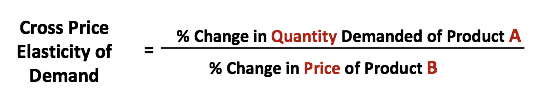

- Based on the above, we need to transform the data from long to wide format to have price of all style_group as features and sales as target variable for each date
- Then for each style_group we can fit a beta regression model to estimate the price elasticity and cross price elasticity of demand

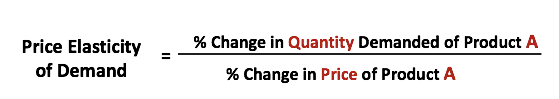

In [ ]:
f = pd.read_csv('../data/transaction_grid.csv')
df['l3_l4'] = df['level3'] + '_' + df['level4']
df['holiday_flag'] = df['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
df['month'] = df['transaction_date'].dt.month
price_sensitivity_holiday = pd.DataFrame(df.groupby(['l3_l4','holiday_flag']).agg({'units_sold':['max','min','mean']\
    ,'final_price':['mean'],'season_start_date':['max'],'season_end_date':['max']})).reset_index()
price_sensitivity_holiday   

In [ ]:
# df['holiday_flag'] = df['transaction_date'].apply(lambda x: 0 if holidays.DE().get(x) is None else 1)
#convert to month name
import calendar
df['month'] = df['transaction_date'].dt.month
price_sensitivity_month = pd.DataFrame(df.groupby(['l3_l4','month']).agg({'units_sold':['max','min','mean']\
    ,'final_price':['mean']})).reset_index()
price_sensitivity_month.columns = ['_'.join(x) for x in price_sensitivity_month.columns.ravel()]
#sort it with l3_l4 and month
price_sensitivity_month = price_sensitivity_month.sort_values(by=['l3_l4_','month_'])
price_sensitivity_month['month_'] = price_sensitivity_month['month_'].apply(lambda x: calendar.month_abbr[x])

In [ ]:
for i in unique_l3_l4:
    temp = price_sensitivity_month[price_sensitivity_month.l3_l4_ == i][['final_price_mean','month_','units_sold_mean','units_sold_max', 'units_sold_min']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.month_,temp.units_sold_max,'r',label='max_sales')
    plt.plot(temp.month_,temp.units_sold_min,'b',label='min_sales')
    plt.plot(temp.month_,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    #second y axis for price
    ax2 = plt.twinx()
    ax2.plot(temp.month_,temp.final_price_mean,'y',label='mean_price')
    
    plt.legend()
    #regression plot with confidence interval    
    plt.title(f'product_code {i}')
    plt.legend()
    plt.xlabel("month")
    #remove negative from y axis
    plt.ylim(bottom=0)
    
    plt.show()

In [ ]:
price_sensitivity['revenue'] = price_sensitivity['final_price_round_'] * price_sensitivity['units_sold_mean']
for i in unique_l3_l4:
    temp = price_sensitivity[price_sensitivity.l3_l4_ == i][['final_price_round_','units_sold_max','units_sold_min','units_sold_mean','revenue']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_round_,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    plt.xlabel("daily_price")
    ax2 = plt.twinx()
    ax2.plot(temp.final_price_round_,temp.revenue,'b',label='mean_revenue')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_round_, y=temp.revenue, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'product_code {i}')
    #put the legend in bottom right
    plt.legend(loc='lower right')
    
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_round_,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

#### Price and revenue moves in same direction
#### so the price maximising the sales is same as price maximising the revenue
#### But it should depend on the month/season as well

#### Seasonal price recommendation

- Dynamic pricing

In [ ]:
trousers_long = price_sensitivity_month[price_sensitivity_month.l3_l4_ == 'Trousers_long'][['final_price_mean','month_','units_sold_mean','units_sold_max', 'units_sold_min','revenue']]
unique_month = trousers_long.month_.unique()

#make it season with grouping months into season
season = {'spring':['Mar','Apr','May'],'summer':['Jun','Jul','Aug'],'autumn':['Sep','Oct','Nov'],'winter':['Dec','Jan','Feb']}
#apply this season to month column
trousers_long['season'] = trousers_long['month_'].apply(lambda x: [k for k,v in season.items() if x in v][0])
unique_season = trousers_long.season.unique()
price_sensitivity_month['revenue'] = price_sensitivity_month['final_price_mean'] * price_sensitivity_month['units_sold_mean']
for i in unique_season:
    temp = trousers_long[trousers_long.season == i][['revenue',
       'units_sold_mean', 'final_price_mean']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_mean,temp.units_sold_mean,'g',label='mean_sales')
    plt.legend()
    plt.xlabel("price")
    ax2 = plt.twinx()
    ax2.plot(temp.final_price_mean,temp.revenue,'b',label='mean_revenue')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_mean, y=temp.revenue, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'season {i}')
    #put the legend in bottom right
    plt.legend(loc='lower right')
    
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_mean,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

In [ ]:

import seaborn as sns
df['final_price_round'] = np.round(df['final_price']).astype(int)
price_sensitivity = pd.DataFrame(df.groupby(['l3_l4','final_price_round']).agg({'units_sold':['max','min','std','mean']})).reset_index()
price_sensitivity = price_sensitivity[(price_sensitivity['units_sold']['std'] > 0)]
price_sensitivity.columns = ['_'.join(x) for x in price_sensitivity.columns.ravel()]
unique_style_group = df.style_group.unique()
unique_l3_l4 = df.l3_l4.unique()
for i in unique_l3_l4:
    temp = price_sensitivity[price_sensitivity.l3_l4_ == i][['final_price_round_','units_sold_max','units_sold_min','units_sold_mean']]
    #make price bin with interval of 1 and group by mean, min and max

    fig.set_size_inches(10,3)
    plt.plot(temp.final_price_round_,temp.units_sold_max,'r',label='max')
    plt.plot(temp.final_price_round_,temp.units_sold_min,'b',label='min')
    plt.plot(temp.final_price_round_,temp.units_sold_mean,'g',label='mean')

    #regression plot with confidence interval
    sns.regplot(x=temp.final_price_round_, y=temp.units_sold_mean, line_kws={"color":"y","alpha":0.5,"lw":2},ci=95,\
        scatter_kws={"color":"b","alpha":0.9,"s":100},marker='.')    
    plt.title(f'product_code {i}')
    plt.legend()
    plt.xlabel("daily_price")
    #remove negative from y axis
    plt.ylim(bottom=0)
    plt.ylabel("sales")
    plt.show()
    #print the correlation coefficient
    cor = round(np.corrcoef(temp.final_price_round_,temp.units_sold_mean)[0][1] * 100,2)
    #print the correlation coefficient red if negative and green if positive
    if cor < 0:
        print('')
        print('relationship with price:',colored(cor,'green'))
    else:
        print('relationship with price:',colored(cor,'red'))

##### style_group level   

In [ ]:

#to avoid long style_group names
style = {}
for i,style_group in enumerate(unique_style_group):
    style[style_group] = f'style_{i+1}'

df_price = df[['style_group', 'transaction_date','sales_price','units_sold','level3','level4']]
df_price = df_price['style_group'].map(style).to_frame().join(df_price.drop('style_group', axis=1))
df_price['l3_l4'] = df_price['level3'] + '_' + df_price['level4']
df_price_cross = df_price.pivot(index='transaction_date', columns='style_group', values=['sales_price','units_sold'])

df_price_cross.columns = ['_'.join(x) for x in df_price_cross.columns.ravel()]
df_price_cross.head()

##### Individual OLS model to estimate price elasticity and cross-price elasticity 

In [ ]:
import statsmodels.api as sm

for i in list(style.values()):
    #keep all price related columns
    print(f'for style_group {i}')
    style_df = pd.concat([df_price_cross.iloc[:,0:8], df_price_cross[f'units_sold_{i}']], axis=1).dropna()
    model = sm.OLS(style_df[f'units_sold_{i}'],style_df.drop([f'units_sold_{i}'],axis=1),missing='drop')
    result = model.fit()
    results_summary = result.summary()
    display(results_summary)

##### These co-efficients provides us the price and cross price elasticity for each style_group

- For most of the style group we see negative price elasticity(co-efficient value own style) which is expected
- For cross price elasticity we see mix of positive values and negative values which is expected as some style_group are complements and some are substitutes
- Based on these co-efficients we can also simulate/estimate unit_sold(sales) for a given price level for each style_group

- We can have the estimate the elasticity at level4 level

In [ ]:
### 

df_price = df[['style_group', 'transaction_date','final_price','units_sold','level3','level4']]
# df_price = df_price['style_group'].map(style).to_frame().join(df_price.drop('style_group', axis=1))
df_price['l3_l4'] = df_price['level3'] + '_' + df_price['level4']
df_price = df_price[['l3_l4','transaction_date','final_price','units_sold']].groupby(['l3_l4','transaction_date'],as_index=False).agg({'final_price':'mean','units_sold':'sum'})
df_price_cross = df_price.pivot(index='transaction_date', columns='l3_l4', values=['final_price','units_sold'])

df_price_cross.columns = ['_'.join(x) for x in df_price_cross.columns.ravel()]
df_price_cross.head()

In [ ]:
unique_l3_l4 = df_price['l3_l4'].unique()
for i in unique_l3_l4:
    #keep all price related columns
    print(f'for style_group {i}')
    style_df = pd.concat([df_price_cross.iloc[:,0:4], df_price_cross[f'units_sold_{i}']], axis=1)
    model = sm.OLS(np.log1p(style_df[f'units_sold_{i}']),style_df.drop([f'units_sold_{i}'],axis=1),missing='drop')
    result = model.fit()
    results_summary = result.summary()
    display(results_summary)

##### While most of the products at level_4 are having negative elasticity, only 'final_price_Trousers_short' is the exception with both elasticity and cross-price elasticity is positive.

- A possible remidy for this to conduct a Bayesian analysis to estimate the price elasticity and cross-price elasticity with prior distribution(eg. Half-Normal distribution) of the co-efficients

- From this co-efficient we can infer the substitutability or complementarity of the products.eg. Trousers_long and short-sleeve_tshirt are complements.

### Improvement and Future work(with more time)

- A) As it's time series other features to be considered like seasonality, trend, promotion etc along with price features.
- B) To estimate the more correct estimation we need to detrend and deseasonalize the data before fitting the model.
- C) Bayesian regression with informed priors distribution of the co-efficients and to have more accurate and intuitive estimation of the price elasticity and cross-price elasticity.
- D) Recommndation of optimum price level on daily/weekly basis.